Colab — Drive Persistence Helper (mount + sync papers/)

Purpose:
- Mount Google Drive
- Define a persistent project folder in Drive
- Auto-restore papers/ (and other outputs) after runtime restarts
- Auto-save back to Drive at the end (you can call save_to_drive())
Usage:
- Put this cell at the VERY TOP of your Colab notebook.
- Run it once per fresh session before Step 1 / Step 2.

## Mount Google Drive

In [34]:
from google.colab import drive  # type: ignore
import os, shutil
from pathlib import Path

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
# === 1) Configure persistent project directory in Drive ===
# Change this if you want a different location in Drive.
DRIVE_PROJECT_ROOT = Path('/content/drive/MyDrive/llm_meta_analysis')
DRIVE_PROJECT_ROOT.mkdir(parents=True, exist_ok=True)

# Local working directory in Colab runtime
LOCAL_PROJECT_ROOT = Path('/content/llm_meta_analysis')
LOCAL_PROJECT_ROOT.mkdir(parents=True, exist_ok=True)

# Subfolders we want to persist (you can add more later)
PERSIST_FOLDERS = [
    'papers',                 # PDFs, metadata, README
    'papers/extracted',       # Step 2 outputs
]

# === 2) Helper: copy folder (Drive <-> Local) ===
def copy_dir(src: Path, dst: Path):
    """Recursively copy src directory into dst (creates dst if needed)."""
    src = Path(src); dst = Path(dst)
    if not src.exists():
        return
    dst.mkdir(parents=True, exist_ok=True)
    for root, dirs, files in os.walk(src):
        rel = Path(root).relative_to(src)
        (dst / rel).mkdir(parents=True, exist_ok=True)
        for f in files:
            s = Path(root) / f
            d = (dst / rel) / f
            # Skip if same size (cheap dedupe)
            if d.exists() and d.stat().st_size == s.stat().st_size:
                continue
            shutil.copy2(s, d)

# === 3) Auto-restore persisted folders from Drive to Local ===
for sub in PERSIST_FOLDERS:
    drive_path = DRIVE_PROJECT_ROOT / sub
    local_path = LOCAL_PROJECT_ROOT / sub
    if drive_path.exists():
        print(f"[RESTORE] {drive_path} → {local_path}")
        copy_dir(drive_path, local_path)
    else:
        print(f"[INIT] Create {drive_path}")
        drive_path.mkdir(parents=True, exist_ok=True)

# === 4) Change working directory to local project root ===
import os as _os
_os.chdir(LOCAL_PROJECT_ROOT)
print(f"Working directory set to: {Path.cwd()}")

# === 5) Helper: save local folders back to Drive ===
def save_to_drive():
    """Copy all PERSIST_FOLDERS from Local → Drive. Call this at the end of your run."""
    for sub in PERSIST_FOLDERS:
        local_path = LOCAL_PROJECT_ROOT / sub
        drive_path = DRIVE_PROJECT_ROOT / sub
        if local_path.exists():
            print(f"[SAVE] {local_path} → {drive_path}")
            copy_dir(local_path, drive_path)
        else:
            print(f"[SKIP] {local_path} does not exist.")
    print("[DONE] Saved to Drive.")

# === 6) Tip: call save_to_drive() when done ===
print("Hint: call save_to_drive() at the end of Step 1 / Step 2 to persist outputs.")

[RESTORE] /content/drive/MyDrive/llm_meta_analysis/papers → /content/llm_meta_analysis/papers
[RESTORE] /content/drive/MyDrive/llm_meta_analysis/papers/extracted → /content/llm_meta_analysis/papers/extracted
Working directory set to: /content/llm_meta_analysis
Hint: call save_to_drive() at the end of Step 1 / Step 2 to persist outputs.


In [36]:
# Quick checks (English titles & comments)
# 1) List PDF files under the working directory
import glob, os, pandas as pd
print("Working dir:", os.getcwd())
print("PDF count:", len(glob.glob("papers/*.pdf")))
print("CSV exists:", os.path.exists("papers/selected_papers_metadata.csv"))

# 2) Preview metadata (first 2 rows)
if os.path.exists("papers/selected_papers_metadata.csv"):
    df = pd.read_csv("papers/selected_papers_metadata.csv")
    display(df.head(2))

Working dir: /content/llm_meta_analysis
PDF count: 5
CSV exists: True


,arxiv_id,title,authors,published,primary_category,categories,summary,pdf_url,comment,journal_ref,doi
0,http://arxiv.org/abs/2508.05496v1,InfiAlign: A Scalable and Sample-Efficient Fra...,"Shuo Cai, Su Lu, Qi Zhou, Kejing Yang, Zhijie ...",2025-08-07,cs.AI,cs.AI,Large language models (LLMs) have exhibited im...,http://arxiv.org/pdf/2508.05496v1,NaN,NaN,NaN
1,http://arxiv.org/abs/2508.05635v1,Genie Envisioner: A Unified World Foundation P...,"Yue Liao, Pengfei Zhou, Siyuan Huang, Donglin ...",2025-08-07,cs.RO,"cs.RO, cs.CV","We introduce Genie Envisioner (GE), a unified ...",http://arxiv.org/pdf/2508.05635v1,https://genie-envisioner.github.io/,NaN,NaN


## Environment Setup

In [37]:
!pip -q install arxiv pandas tqdm python-dateutil pymupdf==1.24.10 >/dev/null

## 1) Imports

In [38]:
from datetime import datetime, timezone
from dateutil import parser as dateparser
import arxiv
import pandas as pd
import re
import os
from pathlib import Path
from tqdm import tqdm
import requests

## 2) Configuration

In [39]:
# You can tweak these values if needed
QUERY = '"instruction tuning" OR "preference optimization" OR "alignment" OR (LLM AND evaluation)'
CATEGORIES = ["cs.CL", "cs.LG"]  # main categories to target
MAX_CANDIDATES = 40  # search breadth (we will re-rank & keep top_k)
TOP_K = 5            # how many PDFs to keep for the project (3–5 recommended)
DATE_FROM = "2024-01-01"  # only recent papers
DATE_TO = datetime.now(timezone.utc).strftime("%Y-%m-%d")
SAVE_DIR = Path("papers")
SAVE_DIR.mkdir(parents=True, exist_ok=True)

## 3) Helper: Clean Abstract/Text

In [40]:
def clean_text(s: str) -> str:
    """Basic cleanup: collapse whitespace and strip."""
    if not s:
        return ""
    s = re.sub(r"\s+", " ", s)
    return s.strip()

## 4) Helper: Score/Re-rank Results

In [41]:
def heuristic_score(entry: arxiv.Result) -> float:
    """Heuristic relevance score combining recency + keyword hits in title/summary."""
    title = (entry.title or "").lower()
    summary = (entry.summary or "").lower()

    # Keyword weights (tune lightly)
    kw = {
        "instruction": 2.0,
        "tuning": 2.0,
        "instruction tuning": 3.0,
        "preference": 1.5,
        "dpo": 2.5,
        "ppo": 2.0,
        "alignment": 1.5,
        "evaluat": 1.2,   # captures evaluate/evaluation
        "benchmark": 1.0,
        "sft": 1.5,
    }

    score = 0.0
    text = f"{title} {summary}"
    for k, w in kw.items():
        if k in text:
            score += w

    # Recency boost: newer is better (linear decay ~ 365 days)
    try:
        published = entry.published or entry.updated
        days = (datetime.now(timezone.utc) - published).days
        recency = max(0.0, 1.0 - (days / 365.0))  # between 0 and ~1
        score += 2.0 * recency
    except Exception:
        pass

    # Category bonus if in target categories
    if any(cat.term in CATEGORIES for cat in entry.categories):
        score += 0.5

    return score

## 5) Query ArXiv and Collect Candidates

In [42]:
print("Searching arXiv... This may take ~10-20 seconds.")
search = arxiv.Search(
    query=QUERY,
    max_results=MAX_CANDIDATES,
    sort_by=arxiv.SortCriterion.SubmittedDate,
    sort_order=arxiv.SortOrder.Descending,
)

candidates = []
for result in search.results():
    # Filter by date window
    pub_dt = result.published or result.updated
    if pub_dt is None:
        continue
    if pub_dt.date() < dateparser.parse(DATE_FROM).date():
        continue
    if pub_dt.date() > dateparser.parse(DATE_TO).date():
        continue

    candidates.append(result)

print(f"Found {len(candidates)} recent candidates.")

Searching arXiv... This may take ~10-20 seconds.


/tmp/ipython-input-313655304.py:10: DeprecationWarning: The 'Search.results' method is deprecated, use 'Client.results' instead
  for result in search.results():


Found 40 recent candidates.


## 6) Patch: Robust category handling + re-run ranking & metadata

In [43]:
# === Patch: Robust category handling + re-run ranking & metadata (Steps 6–7) ===
# This cell fixes the 'str' object has no attribute 'term' error by normalizing categories.

# -- Helper: normalize categories to a list[str] --
def get_category_terms(entry) -> list:
    """
    Return categories as list[str] regardless of arxiv library version.
    Supports both: list[str] and list[objects with .term].
    """
    cats = getattr(entry, "categories", None)
    if not cats:
        return []
    terms = []
    for cat in cats:
        # If cat is an object with .term, use it; otherwise assume it's already a string.
        term = getattr(cat, "term", None)
        terms.append(term if term is not None else str(cat))
    return terms

# -- Updated scorer using normalized categories --
def heuristic_score(entry) -> float:
    """
    Heuristic relevance score combining keyword hits, recency, and category bonus.
    """
    title = (getattr(entry, "title", "") or "").lower()
    summary = (getattr(entry, "summary", "") or "").lower()

    # Keyword weights (light tuning)
    kw = {
        "instruction": 2.0,
        "tuning": 2.0,
        "instruction tuning": 3.0,
        "preference": 1.5,
        "dpo": 2.5,
        "ppo": 2.0,
        "alignment": 1.5,
        "evaluat": 1.2,   # evaluate/evaluation
        "benchmark": 1.0,
        "sft": 1.5,
    }

    score = 0.0
    text = f"{title} {summary}"
    for k, w in kw.items():
        if k in text:
            score += w

    # Recency boost
    from datetime import datetime, timezone
    try:
        published = getattr(entry, "published", None) or getattr(entry, "updated", None)
        if published:
            days = (datetime.now(timezone.utc) - published).days
            recency = max(0.0, 1.0 - (days / 365.0))
            score += 2.0 * recency
    except Exception:
        pass

    # Category bonus
    terms = get_category_terms(entry)
    if any(term in CATEGORIES for term in terms):
        score += 0.5

    return score

# -- Re-run Step 6: Rank and Select Top-K --
scored = [(heuristic_score(r), r) for r in candidates]
scored.sort(key=lambda x: x[0], reverse=True)
selected = [r for _, r in scored[:TOP_K]]

# -- Rebuild metadata safely (Step 7) --
def clean_text(s: str) -> str:
    import re
    if not s:
        return ""
    s = re.sub(r"\s+", " ", s)
    return s.strip()

rows = []
for r in selected:
    authors = ", ".join(a.name for a in getattr(r, "authors", []) or [])
    # Try pdf_url, else build from entry_id
    pdf_url = getattr(r, "pdf_url", None)
    if not pdf_url:
        entry_id = getattr(r, "entry_id", "")
        if entry_id:
            import re as _re
            pdf_url = _re.sub(r"/abs/", "/pdf/", entry_id) + ".pdf"

    # Categories normalized
    cats = get_category_terms(r)
    primary_cat = getattr(r, "primary_category", "")
    if hasattr(primary_cat, "term"):  # some versions expose object
        primary_cat = primary_cat.term

    rows.append({
        "arxiv_id": getattr(r, "entry_id", ""),
        "title": clean_text(getattr(r, "title", "")),
        "authors": authors,
        "published": (getattr(r, "published", None) or getattr(r, "updated", None)).strftime("%Y-%m-%d"),
        "primary_category": primary_cat,
        "categories": ", ".join(cats),
        "summary": clean_text(getattr(r, "summary", "")),
        "pdf_url": pdf_url,
        "comment": getattr(r, "comment", ""),
        "journal_ref": getattr(r, "journal_ref", ""),
        "doi": getattr(r, "doi", ""),
    })

meta_df = pd.DataFrame(rows)
meta_csv_path = SAVE_DIR / "selected_papers_metadata.csv"
meta_df.to_csv(meta_csv_path, index=False)
print(f"Saved metadata CSV → {meta_csv_path.resolve()}")
meta_df

Saved metadata CSV → /content/llm_meta_analysis/papers/selected_papers_metadata.csv


,arxiv_id,title,authors,published,primary_category,categories,summary,pdf_url,comment,journal_ref,doi
0,http://arxiv.org/abs/2508.05496v1,InfiAlign: A Scalable and Sample-Efficient Fra...,"Shuo Cai, Su Lu, Qi Zhou, Kejing Yang, Zhijie ...",2025-08-07,cs.AI,cs.AI,Large language models (LLMs) have exhibited im...,http://arxiv.org/pdf/2508.05496v1,None,None,None
1,http://arxiv.org/abs/2508.05635v1,Genie Envisioner: A Unified World Foundation P...,"Yue Liao, Pengfei Zhou, Siyuan Huang, Donglin ...",2025-08-07,cs.RO,"cs.RO, cs.CV","We introduce Genie Envisioner (GE), a unified ...",http://arxiv.org/pdf/2508.05635v1,https://genie-envisioner.github.io/,None,None
2,http://arxiv.org/abs/2508.05609v1,Hi3DEval: Advancing 3D Generation Evaluation w...,"Yuhan Zhang, Long Zhuo, Ziyang Chu, Tong Wu, Z...",2025-08-07,cs.CV,cs.CV,Despite rapid advances in 3D content generatio...,http://arxiv.org/pdf/2508.05609v1,Page: https://zyh482.github.io/Hi3DEval/,None,None
3,http://arxiv.org/abs/2508.05553v1,Do Political Opinions Transfer Between Western...,"Franziska Weeber, Tanise Ceron, Sebastian Padó",2025-08-07,cs.CL,"cs.CL, cs.CY, I.2.7; J.4",Public opinion surveys show cross-cultural dif...,http://arxiv.org/pdf/2508.05553v1,None,None,None
4,http://arxiv.org/abs/2508.05512v1,RankArena: A Unified Platform for Evaluating R...,"Abdelrahman Abdallah, Mahmoud Abdalla, Bhawna ...",2025-08-07,cs.IR,cs.IR,Evaluating the quality of retrieval-augmented ...,http://arxiv.org/pdf/2508.05512v1,Accept at CIKM 2025,None,None


## 7) Download PDFs

In [44]:
# This cell downloads the selected PDFs with retries and sanity checks.

import time
import requests
from pathlib import Path
import re

SAVE_DIR = Path("papers")
SAVE_DIR.mkdir(parents=True, exist_ok=True)

def is_probably_pdf(path: Path) -> bool:
    """
    Minimal sanity check: non-empty file and starts with %PDF.
    """
    try:
        if not path.exists() or path.stat().st_size < 1024:  # at least 1KB
            return False
        with open(path, "rb") as f:
            head = f.read(5)
        return head.startswith(b"%PDF")
    except Exception:
        return False

def download_file(url: str, out_path: Path, max_retries: int = 3, backoff: float = 2.0) -> bool:
    """
    Stream-download a file with basic retries and exponential backoff.
    """
    for attempt in range(1, max_retries + 1):
        try:
            with requests.get(url, stream=True, timeout=60) as r:
                r.raise_for_status()
                with open(out_path, "wb") as f:
                    for chunk in r.iter_content(chunk_size=8192):
                        if chunk:
                            f.write(chunk)
            if is_probably_pdf(out_path):
                return True
            else:
                print(f"[WARN] File downloaded but failed PDF check: {out_path.name}")
        except Exception as e:
            print(f"[WARN] Attempt {attempt}/{max_retries} failed for {url}: {e}")
        # backoff before retrying
        time.sleep(backoff * attempt)
    return False

# Build names and download
pdf_paths = []
failures = []

if 'meta_df' not in globals():
    raise RuntimeError("metadata DataFrame 'meta_df' not found. Please re-run Step 6–7.")

for i, row in meta_df.iterrows():
    title = row.get("title", f"paper_{i+1}")
    pdf_url = row.get("pdf_url", "")
    if not pdf_url:
        print(f"[SKIP] No PDF URL for row {i+1} — {title}")
        continue
    title_safe = re.sub(r"[^a-zA-Z0-9_-]+", "_", title)[:120]
    out_path = SAVE_DIR / f"{i+1:02d}_{title_safe}.pdf"
    ok = download_file(pdf_url, out_path)
    if ok:
        pdf_paths.append(str(out_path.resolve()))
        print(f"[OK] {out_path.name}")
    else:
        failures.append((title, pdf_url))
        print(f"[FAIL] {title} — {pdf_url}")

print("\nSummary:")
print(f"  Successful PDFs: {len(pdf_paths)}")
print(f"  Failed: {len(failures)}")
if failures:
    print("  Failed entries:")
    for title, url in failures:
        print(f"   - {title} — {url}")

[OK] 01_InfiAlign_A_Scalable_and_Sample-Efficient_Framework_for_Aligning_LLMs_to_Enhance_Reasoning_Capabilities.pdf
[OK] 02_Genie_Envisioner_A_Unified_World_Foundation_Platform_for_Robotic_Manipulation.pdf
[OK] 03_Hi3DEval_Advancing_3D_Generation_Evaluation_with_Hierarchical_Validity.pdf
[OK] 04_Do_Political_Opinions_Transfer_Between_Western_Languages_An_Analysis_of_Unaligned_and_Aligned_Multilingual_LLMs.pdf
[OK] 05_RankArena_A_Unified_Platform_for_Evaluating_Retrieval_Reranking_and_RAG_with_Human_and_LLM_Feedback.pdf

Summary:
  Successful PDFs: 5
  Failed: 0


## 9) — Generate README.md with Paper List

In [45]:
# This file will be useful for GitHub submission and quick reference.

readme_path = SAVE_DIR / "README.md"
with open(readme_path, "w", encoding="utf-8") as f:
    f.write("# Selected Papers for LLM Meta-Analysis\n\n")
    f.write(f"Query used: `{QUERY}`\n\n")
    f.write("## Papers\n\n")
    for i, row in meta_df.iterrows():
        title = row["title"]
        authors = row["authors"]
        date = row["published"]
        link = row["arxiv_id"]
        pdf = row["pdf_url"]
        f.write(f"- **{title}** ({date}) — {authors}\n")
        f.write(f"  - Abstract: {link}\n")
        f.write(f"  - PDF: {pdf}\n\n")

print(f"README generated → {readme_path.resolve()}")

# === Step 10 — Next Steps Guidance ===
print("\nNEXT STEPS:")
print("1) Review the CSV file: papers/selected_papers_metadata.csv")
print("2) Skim through the PDFs in papers/ to understand their content.")
print("3) Confirm the 3–5 papers you will include in your meta-analysis.")
print("4) Proceed to Step 2: Structured extraction of key sections (title, problem, method, data, metrics, results).")
print("5) Step 3: Comparative analysis with tables and charts.")
print("6) Step 4: Write your final report in Markdown and export to PDF.")
print("7) Step 5: Push PDF, README.md, and supporting files to your GitHub repo.")

README generated → /content/llm_meta_analysis/papers/README.md

NEXT STEPS:
1) Review the CSV file: papers/selected_papers_metadata.csv
2) Skim through the PDFs in papers/ to understand their content.
3) Confirm the 3–5 papers you will include in your meta-analysis.
4) Proceed to Step 2: Structured extraction of key sections (title, problem, method, data, metrics, results).
5) Step 3: Comparative analysis with tables and charts.
6) Step 4: Write your final report in Markdown and export to PDF.
7) Step 5: Push PDF, README.md, and supporting files to your GitHub repo.


In [46]:
save_to_drive()

[SAVE] /content/llm_meta_analysis/papers → /content/drive/MyDrive/llm_meta_analysis/papers
[SAVE] /content/llm_meta_analysis/papers/extracted → /content/drive/MyDrive/llm_meta_analysis/papers/extracted
[DONE] Saved to Drive.


# Step 2: Structured PDF Extraction

Purpose:
Parse each downloaded PDF (Step 1) and build a structured dataset with:
- title, authors, year, venue
- research_problem, proposed_solution, main_results
- datasets, model_architecture, evaluation_metrics
Save outputs as CSV + JSONL for Step 3.

In [47]:
!pip -q install pymupdf==1.24.10 pandas tqdm transformers sentencepiece accelerate > /dev/null

## 1) Imports

In [48]:
import os
import re
import json
from pathlib import Path
import pandas as pd
from tqdm import tqdm
import fitz  # PyMuPDF

## 2) Hugging Face Model Setup (Optional, GPU Recommended)

In [49]:
USE_LOCAL_HF = True  # Set to True if you want to run local summarization using GPU
HF_MODEL_NAME = "google/flan-t5-base"  # Change to flan-t5-large for higher quality if GPU has enough memory

if USE_LOCAL_HF:
    from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
    import torch
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tokenizer = AutoTokenizer.from_pretrained(HF_MODEL_NAME)
    model = AutoModelForSeq2SeqLM.from_pretrained(HF_MODEL_NAME).to(device)

## 3) Paths & Load Metadata

In [50]:
PAPERS_DIR = Path("papers")
META_CSV = PAPERS_DIR / "selected_papers_metadata.csv"
OUT_DIR = PAPERS_DIR / "extracted"
OUT_DIR.mkdir(parents=True, exist_ok=True)
SECTIONS_DIR = OUT_DIR / "sections_raw"
SECTIONS_DIR.mkdir(parents=True, exist_ok=True)

assert META_CSV.exists(), "Metadata CSV not found. Please complete Step 1."
meta_df = pd.read_csv(META_CSV)

## 4) PDF → Plain Text Extraction

In [51]:
def extract_pdf_text(pdf_path: Path) -> str:
    """Extract plain text from a PDF using PyMuPDF."""
    parts = []
    with fitz.open(pdf_path) as doc:
        for page in doc:
            parts.append(page.get_text("text"))
    text = "\n\n".join(parts)
    return re.sub(r"\s+", " ", text).strip()

## 5) Heuristic Section Splitter

In [52]:
SECTION_PATTERNS = [
    ("abstract", r"\babstract\b"),
    ("introduction", r"\bintroduction\b"),
    ("method", r"\bmethod(s)?\b|\bapproach\b|\bmodel\b"),
    ("results", r"\bresults?\b|\bevaluation\b|\bmetrics\b|\bbenchmark\b"),
    ("datasets", r"\bdatasets?\b|\bdata\b"),
    ("conclusion", r"\bconclusion(s)?\b|\bdiscussion\b|\blimitation(s)?\b"),
]

def split_into_sections(text: str) -> dict:
    anchors = []
    for key, pat in SECTION_PATTERNS:
        for m in re.finditer(pat, text, flags=re.IGNORECASE):
            anchors.append((m.start(), key))
    if not anchors:
        return {"body": text}
    anchors.sort(key=lambda x: x[0])
    sections = {}
    for i, (start_idx, key) in enumerate(anchors):
        end_idx = anchors[i + 1][0] if i + 1 < len(anchors) else len(text)
        sections[key] = text[start_idx:end_idx].strip()
    return sections

## 6) Local HF Summarization Helper (Optional)

In [53]:
SUMMARY_PROMPT = (
    "Extract a concise JSON with keys: research_problem, proposed_solution, main_results, datasets, model_architecture, evaluation_metrics. "
    "Short phrases only. If unknown, use an empty string.\n\nPaper content:\n"
)
JSON_KEYS = ["research_problem", "proposed_solution", "main_results", "datasets", "model_architecture", "evaluation_metrics"]

def hf_summarize_to_json(text: str) -> dict:
    if not USE_LOCAL_HF:
        return {k: "" for k in JSON_KEYS}
    snippet = text[:5000]
    prompt = SUMMARY_PROMPT + snippet + "\n\nReturn JSON only."
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=1024).to(model.device)
    with torch.no_grad():
        outputs = model.generate(**inputs, max_new_tokens=256, do_sample=False)
    decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
    try:
        m = re.search(r"\{.*\}", decoded, flags=re.DOTALL)
        if m:
            data = json.loads(m.group(0))
            return {k: str(data.get(k, "")).strip() for k in JSON_KEYS}
    except Exception:
        pass
    return {k: "" for k in JSON_KEYS}

## 7) Process PDFs and Build Structured Rows

In [54]:
# === Utility: Clean scientific noise from text (improved) ===
def clean_scientific_noise(text: str) -> str:
    """Lightly clean references, citations, and noisy sections from scientific text."""
    # Cut off after common tail sections
    cut_patterns = [r"\breferences\b", r"\bbibliography\b", r"\backnowledg(e)?ments\b", r"\bappendix\b"]
    cut_pos = len(text)
    for pat in cut_patterns:
        m = re.search(pat, text, flags=re.IGNORECASE)
        if m:
            cut_pos = min(cut_pos, m.start())
    text = text[:cut_pos]

    # Remove bracketed numeric citations [12] or [3, 7]
    text = re.sub(r"\[(?:\s*\d+\s*(?:,\s*\d+\s*)*)\]", "", text)

    # Remove date ranges like (2013–2014)
    text = re.sub(r"\(\d{4}(–\d{4})?\)", "", text)

    # Remove arXiv IDs
    text = re.sub(r"arXiv:\s*\d{4}\.\d{4,5}(v\d+)?", "", text, flags=re.IGNORECASE)

    # Collapse whitespace
    text = re.sub(r"\s+", " ", text).strip()
    return text

In [61]:
# === Utility: Lightweight post-processor for extracted fields (English) ===
def postprocess_field(s: str) -> str:
    """
    Trim spaces, drop bracketed citations like [12] or [3, 7],
    strip leading 'Abstract', and cap length to 600 chars.
    """
    if not s:
        return ""
    s = re.sub(r"\s+", " ", str(s)).strip()
    s = re.sub(r"\[(?:\s*\d+\s*(?:,\s*\d+\s*)*)\]", "", s)
    s = re.sub(r"^\s*Abstract\s*", "", s, flags=re.IGNORECASE)
    return s[:600]

# === Update extract_pdf_text to include cleaning ===
def extract_pdf_text(pdf_path: Path) -> str:
    """Extract plain text from a PDF using PyMuPDF and clean scientific noise."""
    parts = []
    with fitz.open(pdf_path) as doc:
        for page in doc:
            parts.append(page.get_text("text"))
    text = "\n\n".join(parts)
    text = re.sub(r"\s+", " ", text).strip()
    return clean_scientific_noise(text)

# === Reset Step 2 state (safe rebuild) ===
# Start fresh to avoid mixing previous runs with different schemas.
rows = []  # IMPORTANT: reset the accumulator before re-running the loop

# (Optional) Clear previous DataFrame handle if it exists
try:
    del struct_df
except NameError:
    pass

# (Optional) Remove old saved outputs to avoid confusion
from pathlib import Path
for p in [Path("papers/extracted/structured_extraction.csv"),
          Path("papers/extracted/structured_extraction.jsonl")]:
    if p.exists():
        p.unlink()
print("State reset. Now re-run the processing loop (blocks 7→9).")

# === Update venue detection and processing loop ===
for i, meta in tqdm(list(meta_df.iterrows()), desc="Processing PDFs"):
    title = meta.get("title", f"paper_{i+1}")
    authors = meta.get("authors", "")
    published = meta.get("published", "")
    arxiv_id = meta.get("arxiv_id", "")
    journal_ref = str(meta.get("journal_ref", "")).strip()
    venue = journal_ref if journal_ref and journal_ref.lower() != "nan" else "arXiv"

    pdf_path = next(PAPERS_DIR.glob(f"{i+1:02d}_*.pdf"), None)
    if not pdf_path:
        title_safe = re.sub(r"[^a-zA-Z0-9_-]+", "_", title)[:40].lower()
        for p in pdf_files:
            if title_safe in p.name.lower():
                pdf_path = p
                break
    if not pdf_path:
        print(f"[WARN] PDF not found for row {i+1}: {title}")
        continue

    full_text = extract_pdf_text(pdf_path)
    sections = split_into_sections(full_text)

    with open(SECTIONS_DIR / f"{i+1:02d}_sections.json", "w", encoding="utf-8") as f:
        json.dump(sections, f, ensure_ascii=False, indent=2)

    # Build a focused context (Abstract + Method + Results + Intro fallback)
    context = "\n\n".join([
        sections.get("abstract", "")[:1200],
        sections.get("method", "")[:1200],
        sections.get("results", "")[:1200],
        sections.get("introduction", "")[:800],
    ])[:4500]
    model_json = hf_summarize_to_json(context)

    abstract = sections.get("abstract", "")
    intro = sections.get("introduction", "")
    method = sections.get("method", "")
    results = sections.get("results", "")
    datasets = sections.get("datasets", "")

    # Regex safety nets for dataset/metric names (English keywords)
    DATASET_KWS = [
        "MMLU","GSM8K","HumanEval","MBPP","ARC","HellaSwag","TruthfulQA","BBH","SQuAD","MNLI",
        "BoolQ","Winogrande","PIQA","COCO","ImageNet","MIRACL","NaturalQuestions","HotpotQA",
        "TriviaQA","DROP","OpenBookQA","WMT","SuperGLUE","GLUE","MATH"
    ]
    METRIC_KWS = ["accuracy","acc","f1","f-1","precision","recall","rouge","bleu","meteor","exact match","em","ndcg","mrr","map"]

    def _extract_keywords(text, vocab):
        low = text.lower()
        return ", ".join(sorted({kw for kw in vocab if kw.lower() in low}))

    datasets_auto = model_json.get("datasets") or _extract_keywords(" ".join([datasets, results, method]), DATASET_KWS)
    metrics_auto  = model_json.get("evaluation_metrics") or _extract_keywords(results, METRIC_KWS)


    def pick(*cands):
        for c in cands:
            if c and len(c.split()) > 5:
                return re.sub(r"\s+", " ", c).strip()[:600]
        return ""

    structured = {
        "title": title,
        "authors": authors,
        "year": str(published)[:4] if str(published) else "",
        "venue": venue,
        "research_problem": postprocess_field(model_json.get("research_problem") or pick(abstract, intro)),
        "proposed_solution": postprocess_field(model_json.get("proposed_solution") or pick(method, intro)),
        "main_results": postprocess_field(model_json.get("main_results") or pick(results)),
        "datasets": postprocess_field(datasets_auto),
        "model_architecture": postprocess_field(model_json.get("model_architecture") or pick(method)),
        "evaluation_metrics": postprocess_field(metrics_auto),
        "source_pdf": str(pdf_path),
        "arxiv_id": arxiv_id,
    }

    rows.append(structured)

State reset. Now re-run the processing loop (blocks 7→9).


Processing PDFs: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


## 8) Save Structured Outputs

In [62]:
STRUCT_CSV = OUT_DIR / "structured_extraction.csv"
STRUCT_JSONL = OUT_DIR / "structured_extraction.jsonl"

struct_df = pd.DataFrame(rows)
struct_df.to_csv(STRUCT_CSV, index=False)
with open(STRUCT_JSONL, "w", encoding="utf-8") as f:
    for r in rows:
        f.write(json.dumps(r, ensure_ascii=False) + "\n")

print(f"[OK] Saved → {STRUCT_CSV}")
print(f"[OK] Saved → {STRUCT_JSONL}")

[OK] Saved → papers/extracted/structured_extraction.csv
[OK] Saved → papers/extracted/structured_extraction.jsonl


## 9) Quick Preview

In [63]:
struct_df.head()

,title,authors,year,venue,research_problem,proposed_solution,main_results,datasets,model_architecture,evaluation_metrics,source_pdf,arxiv_id
0,InfiAlign: A Scalable and Sample-Efficient Fra...,"Shuo Cai, Su Lu, Qi Zhou, Kejing Yang, Zhijie ...",2025,arXiv,Large language models (LLMs) have exhibited im...,approach integrates both domain- level and sem...,,,approach integrates both domain- level and sem...,,papers/01_InfiAlign_A_Scalable_and_Sample-Effi...,http://arxiv.org/abs/2508.05496v1
1,Genie Envisioner: A Unified World Foundation P...,"Yue Liao, Pengfei Zhou, Siyuan Huang, Donglin ...",2025,arXiv,"We introduce Genie Envisioner (GE), a unified ...","model, enabling predictive reasoning and plann...","evaluation, and the provision of both robotic ...",,"model, enabling predictive reasoning and plann...",,papers/02_Genie_Envisioner_A_Unified_World_Fou...,http://arxiv.org/abs/2508.05635v1
2,Hi3DEval: Advancing 3D Generation Evaluation w...,"Yuhan Zhang, Long Zhuo, Ziyang Chu, Tong Wu, Z...",2025,arXiv,shapes. Future work will aim to extend the,"methods, thereby improving generalization. Soc...",evaluation pipeline enhances scalability and c...,,"methods, thereby improving generalization. Soc...",,papers/03_Hi3DEval_Advancing_3D_Generation_Eva...,http://arxiv.org/abs/2508.05609v1
3,Do Political Opinions Transfer Between Western...,"Franziska Weeber, Tanise Ceron, Sebastian Padó",2025,arXiv,Public opinion surveys show cross-cultural dif...,"model-inherent polit- ical opinions, but opini...",evaluation frame- work from Ceron et al. and e...,,"model-inherent polit- ical opinions, but opini...",,papers/04_Do_Political_Opinions_Transfer_Betwe...,http://arxiv.org/abs/2508.05553v1
4,RankArena: A Unified Platform for Evaluating R...,"Abdelrahman Abdallah, Mahmoud Abdalla, Bhawna ...",2025,arXiv,Evaluating the quality of retrieval-augmented ...,methods: a small number of rerankers dominate ...,results demonstrate a generally strong positiv...,ARC,methods: a small number of rerankers dominate ...,em,papers/05_RankArena_A_Unified_Platform_for_Eva...,http://arxiv.org/abs/2508.05512v1


In [64]:
# === Step 2 — Final tidy pass (prepare for Step 3) ===
# Fix hyphenated line breaks (e.g., "polit- ical" -> "political"), collapse spaces, fill blanks.

import re
CLEAN_COLS = [
    "research_problem","proposed_solution","main_results",
    "datasets","model_architecture","evaluation_metrics"
]

def fix_hyphenation(s: str) -> str:
    if not isinstance(s, str):
        return ""
    # Join words split across lines: "xxx- \nyyy" or "xxx-  yyy" -> "xxxyyy"
    s = re.sub(r"-\s+", "", s)
    # Normalize whitespace
    s = re.sub(r"\s+", " ", s).strip()
    return s

struct_df = struct_df.fillna("")
for c in CLEAN_COLS:
    if c in struct_df.columns:
        struct_df[c] = struct_df[c].map(fix_hyphenation)

# Light fallback: ensure datasets/metrics not totally empty when results mention common names
DATASET_KWS = ["MMLU","GSM8K","HumanEval","MBPP","ARC","HellaSwag","TruthfulQA","BBH","SQuAD","MNLI","BoolQ",
               "Winogrande","PIQA","COCO","ImageNet","MIRACL","NaturalQuestions","HotpotQA","TriviaQA","DROP",
               "OpenBookQA","WMT","SuperGLUE","GLUE","MATH"]
METRIC_KWS = ["accuracy","acc","f1","f-1","precision","recall","rouge","bleu","meteor","exact match","em","ndcg","mrr","map"]

def _extract_keywords(text, vocab):
    low = text.lower()
    return ", ".join(sorted({kw for kw in vocab if kw.lower() in low}))

if "datasets" in struct_df.columns and "results" in struct_df.columns and "model_architecture" in struct_df.columns:
    empty_ds = struct_df["datasets"].str.len() < 2
    struct_df.loc[empty_ds, "datasets"] = struct_df.loc[empty_ds].apply(
        lambda r: _extract_keywords(f"{r.get('results','')} {r.get('model_architecture','')}", DATASET_KWS), axis=1
    )

if "evaluation_metrics" in struct_df.columns and "results" in struct_df.columns:
    empty_mt = struct_df["evaluation_metrics"].str.len() < 2
    struct_df.loc[empty_mt, "evaluation_metrics"] = struct_df.loc[empty_mt, "results"].apply(
        lambda t: _extract_keywords(t, METRIC_KWS)
    )

# Save an analysis-ready file
from pathlib import Path
ANALYSIS_CSV = Path("papers/extracted/analysis_ready.csv")
struct_df.to_csv(ANALYSIS_CSV, index=False)
print(f"[OK] analysis_ready.csv saved → {ANALYSIS_CSV.resolve()}")
display(struct_df.head(5))

[OK] analysis_ready.csv saved → /content/llm_meta_analysis/papers/extracted/analysis_ready.csv


,title,authors,year,venue,research_problem,proposed_solution,main_results,datasets,model_architecture,evaluation_metrics,source_pdf,arxiv_id
0,InfiAlign: A Scalable and Sample-Efficient Fra...,"Shuo Cai, Su Lu, Qi Zhou, Kejing Yang, Zhijie ...",2025,arXiv,Large language models (LLMs) have exhibited im...,approach integrates both domainlevel and seman...,,,approach integrates both domainlevel and seman...,,papers/01_InfiAlign_A_Scalable_and_Sample-Effi...,http://arxiv.org/abs/2508.05496v1
1,Genie Envisioner: A Unified World Foundation P...,"Yue Liao, Pengfei Zhou, Siyuan Huang, Donglin ...",2025,arXiv,"We introduce Genie Envisioner (GE), a unified ...","model, enabling predictive reasoning and plann...","evaluation, and the provision of both robotic ...",,"model, enabling predictive reasoning and plann...",,papers/02_Genie_Envisioner_A_Unified_World_Fou...,http://arxiv.org/abs/2508.05635v1
2,Hi3DEval: Advancing 3D Generation Evaluation w...,"Yuhan Zhang, Long Zhuo, Ziyang Chu, Tong Wu, Z...",2025,arXiv,shapes. Future work will aim to extend the,"methods, thereby improving generalization. Soc...",evaluation pipeline enhances scalability and c...,,"methods, thereby improving generalization. Soc...",,papers/03_Hi3DEval_Advancing_3D_Generation_Eva...,http://arxiv.org/abs/2508.05609v1
3,Do Political Opinions Transfer Between Western...,"Franziska Weeber, Tanise Ceron, Sebastian Padó",2025,arXiv,Public opinion surveys show cross-cultural dif...,"model-inherent political opinions, but opinion...",evaluation framework from Ceron et al. and eva...,,"model-inherent political opinions, but opinion...",,papers/04_Do_Political_Opinions_Transfer_Betwe...,http://arxiv.org/abs/2508.05553v1
4,RankArena: A Unified Platform for Evaluating R...,"Abdelrahman Abdallah, Mahmoud Abdalla, Bhawna ...",2025,arXiv,Evaluating the quality of retrieval-augmented ...,methods: a small number of rerankers dominate ...,results demonstrate a generally strong positiv...,ARC,methods: a small number of rerankers dominate ...,em,papers/05_RankArena_A_Unified_Platform_for_Eva...,http://arxiv.org/abs/2508.05512v1


# Step 3: Comparative Analysis of Selected Papers


In [76]:
# === Auto-enrich evaluation_metrics from PDFs + cleanup (English comments) ===
import re
from pathlib import Path
import fitz  # PyMuPDF
import pandas as pd

CSV_PATH = Path("/content/llm_meta_analysis/papers/extracted/analysis_ready.csv")
df = pd.read_csv(CSV_PATH)

# 1) Define metric vocabulary + regexes (normalize synonyms)
METRIC_SYNONYMS = {
    "exact match": [r"\bexact\s*match\b", r"\bEM\b"],
    "f1":          [r"\bf-?1\b", r"\bf1[- ]?score\b"],
    "accuracy":    [r"\baccuracy\b", r"\bacc\b"],
    "precision":   [r"\bprecision\b"],
    "recall":      [r"\brecall\b"],
    "rouge":       [r"\brouge(?:-[l1-9])?\b"],
    "bleu":        [r"\bbleu\b"],
    "meteor":      [r"\bmeteor\b"],
    "ndcg":        [r"\bndcg(?:@?\d+)?\b"],
    "mrr":         [r"\bmrr\b"],
    "map":         [r"\bmap\b"],
    "hit@1":       [r"\bhit@?1\b", r"\btop-?1\b"],
    "hit@5":       [r"\bhit@?5\b", r"\btop-?5\b"],
}

def read_pdf_text(pdf_path: Path) -> str:
    try:
        parts = []
        with fitz.open(pdf_path) as doc:
            for page in doc:
                parts.append(page.get_text("text"))
        return " ".join(parts)
    except Exception as e:
        print(f"[WARN] Could not read {pdf_path.name}: {e}")
        return ""

def normalize_existing(metrics_str: str) -> set:
    """Split existing metrics, drop blanks and the literal 'nan'."""
    if not isinstance(metrics_str, str):
        return set()
    items = [m.strip().lower() for m in metrics_str.split(",")]
    return {m for m in items if m and m != "nan"}

# 2) Enrich per paper
for idx, row in df.iterrows():
    pdf_file = Path(row["source_pdf"])
    if not pdf_file.is_absolute():
        pdf_file = Path("/content/llm_meta_analysis") / pdf_file
    text = read_pdf_text(pdf_file).lower()

    found = set()
    for norm, patterns in METRIC_SYNONYMS.items():
        for pat in patterns:
            if re.search(pat, text, flags=re.IGNORECASE):
                found.add(norm)
                break

    existing = normalize_existing(row.get("evaluation_metrics", ""))
    all_metrics = existing | found

    # Optional: if nothing found, try light heuristics (look for '%' near keywords)
    if not all_metrics:
        if re.search(r"\baccuracy\b\s*[:=]\s*\d+(\.\d+)?\s*%?", text):
            all_metrics.add("accuracy")
        if re.search(r"\bf-?1\b\s*[:=]\s*\d+(\.\d+)?", text):
            all_metrics.add("f1")

    df.at[idx, "evaluation_metrics"] = ", ".join(sorted(all_metrics))

# 3) Save back
df.to_csv(CSV_PATH, index=False)
print(f"[OK] evaluation_metrics enriched & saved → {CSV_PATH}")


[OK] evaluation_metrics enriched & saved → /content/llm_meta_analysis/papers/extracted/analysis_ready.csv


[OK] Enriched and saved → /content/llm_meta_analysis/papers/extracted/analysis_ready.csv
=== Comparative Table of Selected Papers ===


,title,research_problem,proposed_solution,datasets,evaluation_metrics
0,InfiAlign: A Scalable and Sample-Efficient Fra...,Large language models (LLMs) have exhibited im...,approach integrates both domainlevel and seman...,"InfiAlign, MATH, MMLU","accuracy, em, exact match, precision"
1,Genie Envisioner: A Unified World Foundation P...,"We introduce Genie Envisioner (GE), a unified ...","model, enabling predictive reasoning and plann...","GE-Act, GE-Base, GE-Sim, Genie","bleu, map, precision"
2,Hi3DEval: Advancing 3D Generation Evaluation w...,shapes. Future work will aim to extend the,"methods, thereby improving generalization. Soc...","DROP, Hi3DEval","accuracy, em, exact match, map"
3,Do Political Opinions Transfer Between Western...,Public opinion surveys show cross-cultural dif...,"model-inherent political opinions, but opinion...",DROP,nan
4,RankArena: A Unified Platform for Evaluating R...,Evaluating the quality of retrieval-augmented ...,methods: a small number of rerankers dominate ...,"ARC, BEIR, MS MARCO, RankArena, TREC",em


[OK] Comparative table saved → /content/llm_meta_analysis/papers/extracted/comparative_table.csv


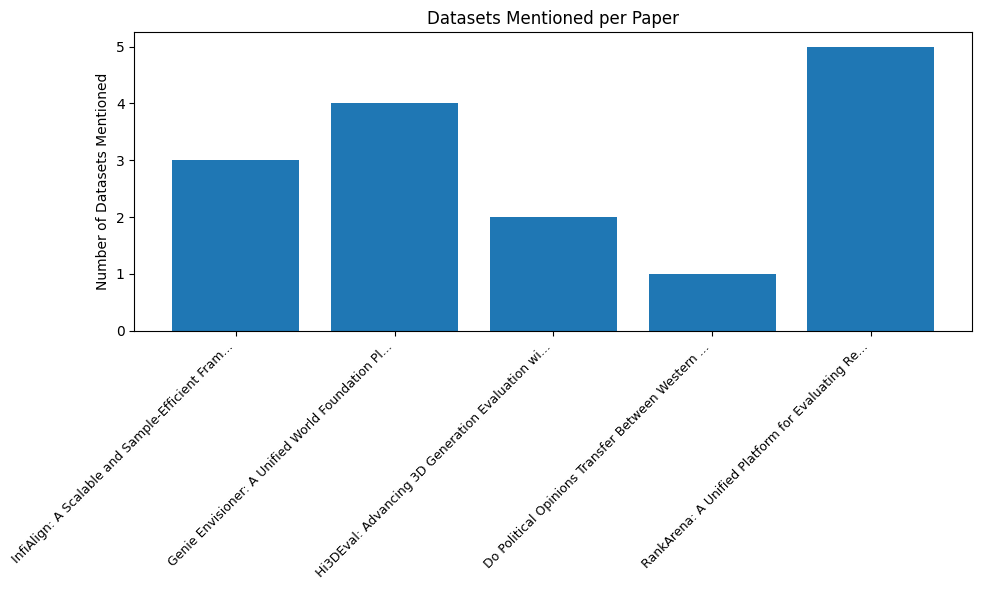

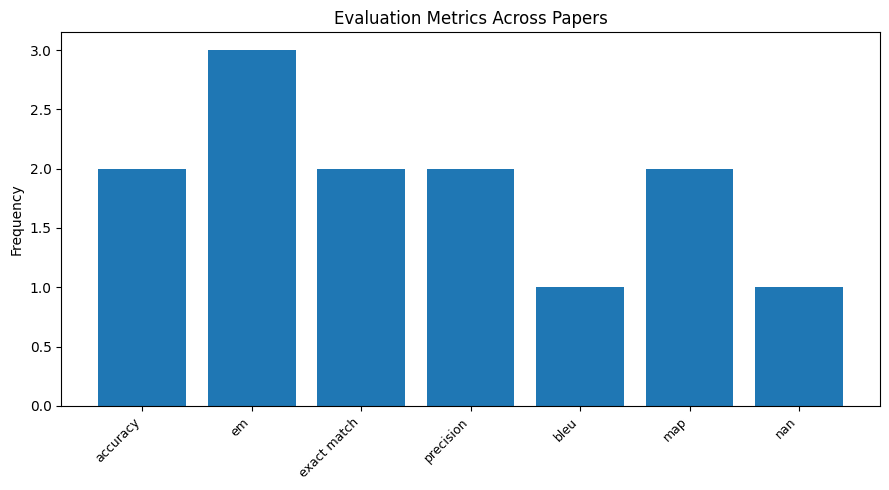

[OK] Metrics summary saved → /content/llm_meta_analysis/papers/extracted/metrics_summary.csv


In [77]:
# === Step 3: Comparative Analysis (Consolidated & Auto-Enriched) ===
import re
from pathlib import Path
import fitz  # PyMuPDF
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# --- 3.0 Load analysis data ---
CSV_PATH = Path("/content/llm_meta_analysis/papers/extracted/analysis_ready.csv")
df = pd.read_csv(CSV_PATH)

# --- 3.1 Auto-enrich datasets & evaluation_metrics from PDFs (no manual edits needed) ---
KNOWN_DATASETS = sorted(set([
    # LLM / NLP general
    "MMLU","BBH","ARC","HellaSwag","TruthfulQA","SQuAD","GLUE","SuperGLUE","MNLI","BoolQ",
    "Winogrande","PIQA","Natural Questions","NQ","HotpotQA","TriviaQA","DROP","OpenBookQA",
    "WMT","XSum","WikiText","Common Crawl","GSM8K","HumanEval","MBPP","MATH",
    # IR / RAG
    "MS MARCO","BEIR","LoTTE","TREC",
    # Vision
    "ImageNet","COCO","CIFAR-10","CIFAR-100",
    # Paper-specific
    "RankArena","Hi3DEval"
]))
KNOWN_METRICS = sorted(set([
    "accuracy","acc","f1","precision","recall","exact match","em","rouge","bleu","meteor","ndcg","mrr","map","hit@1","hit@5"
]))
INTRO_PATTERNS = [
    r"\bwe (introduce|present|propose)\s+([A-Z][A-Za-z0-9\-]{2,})",
    r"\bthis (paper|work)\s+(introduces|presents)\s+([A-Z][A-Za-z0-9\-]{2,})"
]

def read_pdf_text(pdf_path: Path) -> str:
    try:
        parts = []
        with fitz.open(pdf_path) as doc:
            for page in doc:
                parts.append(page.get_text("text"))
        return " ".join(parts)
    except Exception as e:
        print(f"[WARN] Could not read {pdf_path.name}: {e}")
        return ""

for idx, row in df.iterrows():
    pdf_file = Path(row["source_pdf"])
    if not pdf_file.is_absolute():
        pdf_file = Path("/content/llm_meta_analysis") / pdf_file
    text = read_pdf_text(pdf_file)
    low = text.lower()

    # Detect newly introduced benchmark names (e.g., RankArena, Hi3DEval)
    introduced = set()
    for pat in INTRO_PATTERNS:
        for m in re.finditer(pat, text):
            cand = m.group(2) if m.lastindex and m.lastindex >= 2 else None
            if cand and len(cand) <= 30:
                introduced.add(cand)

    # Detect known datasets
    found_ds = {ds for ds in KNOWN_DATASETS if re.search(rf"\b{re.escape(ds)}\b", text, re.IGNORECASE)}
    existing_ds = str(row.get("datasets", "")).strip()
    all_ds = set(d.strip() for d in existing_ds.split(",") if d.strip())
    all_ds |= found_ds | introduced
    # Remove "unspecified ..." if specific names exist
    all_ds = {d for d in all_ds if not d.startswith("unspecified")} or all_ds
    df.at[idx, "datasets"] = ", ".join(sorted(all_ds))

    # Detect evaluation metrics
    found_mt = {mt.lower() for mt in KNOWN_METRICS if re.search(rf"\b{re.escape(mt)}\b", low)}
    existing_mt = str(row.get("evaluation_metrics", "")).strip()
    all_mt = set(m.strip().lower() for m in existing_mt.split(",") if m.strip())
    all_mt |= found_mt
    df.at[idx, "evaluation_metrics"] = ", ".join(sorted(all_mt))

# Save enriched data back
df.to_csv(CSV_PATH, index=False)
print(f"[OK] Enriched and saved → {CSV_PATH}")

# --- 3.2 Comparative table (for the report) ---
compare_cols = ["title","research_problem","proposed_solution","datasets","evaluation_metrics"]
comparative_df = df[compare_cols].copy()
print("=== Comparative Table of Selected Papers ===")
display(comparative_df)

COMPARE_CSV = Path("papers/extracted/comparative_table.csv")
comparative_df.to_csv(COMPARE_CSV, index=False)
print(f"[OK] Comparative table saved → {COMPARE_CSV.resolve()}")

# --- 3.3 Visualization: datasets mentioned per paper ---
short_titles = [t if len(t) < 50 else t[:47] + "..." for t in df["title"]]
datasets_count = df["datasets"].fillna("").apply(lambda x: len([d for d in x.split(",") if d.strip()]))

plt.figure(figsize=(10, 6))
plt.bar(short_titles, datasets_count)
plt.xticks(rotation=45, ha="right", fontsize=9)
plt.ylabel("Number of Datasets Mentioned")
plt.title("Datasets Mentioned per Paper")
plt.tight_layout()
plt.show()

# --- 3.4 Visualization: evaluation metrics frequency across papers ---
metrics_flat = []
for m in df["evaluation_metrics"].fillna(""):
    metrics_flat.extend([x.strip().lower() for x in m.split(",") if x.strip()])
metric_counts = Counter(metrics_flat)

plt.figure(figsize=(9, 5))
plt.bar(list(metric_counts.keys()), list(metric_counts.values()))
plt.xticks(rotation=45, ha="right", fontsize=9)
plt.ylabel("Frequency")
plt.title("Evaluation Metrics Across Papers")
plt.tight_layout()
plt.show()

# --- 3.5 Save metrics summary ---
metrics_df = pd.DataFrame(metric_counts.items(), columns=["metric","count"])
METRICS_CSV = Path("papers/extracted/metrics_summary.csv")
metrics_df.to_csv(METRICS_CSV, index=False)
print(f"[OK] Metrics summary saved → {METRICS_CSV.resolve()}")
